In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
print(os.listdir("images/"))

['Test', 'Train', 'Validation']


In [3]:
SIZE = 256  #Resize images

In [4]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 


In [5]:
for directory_path in glob.glob("images/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

Bacterial leaf blight
images/train\Bacterial leaf blight\DSC_0365.JPG
images/train\Bacterial leaf blight\DSC_0366.jpg
images/train\Bacterial leaf blight\DSC_0367.JPG
images/train\Bacterial leaf blight\DSC_0370.jpg
images/train\Bacterial leaf blight\DSC_0372.JPG
images/train\Bacterial leaf blight\DSC_0373.JPG
images/train\Bacterial leaf blight\DSC_0374.JPG
images/train\Bacterial leaf blight\DSC_0375.JPG
images/train\Bacterial leaf blight\DSC_0376.JPG
images/train\Bacterial leaf blight\DSC_0377.JPG
images/train\Bacterial leaf blight\DSC_0378.JPG
images/train\Bacterial leaf blight\DSC_0379.JPG
images/train\Bacterial leaf blight\DSC_0380.JPG
images/train\Bacterial leaf blight\DSC_0381.JPG
images/train\Bacterial leaf blight\DSC_0382.JPG
images/train\Bacterial leaf blight\DSC_0383.JPG
images/train\Bacterial leaf blight\DSC_0384.JPG
images/train\Bacterial leaf blight\DSC_0385.jpg
images/train\Bacterial leaf blight\DSC_0386.JPG
images/train\Bacterial leaf blight\DSC_0388.JPG
images/train\Bacte

In [6]:
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [7]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("images/validation/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

In [8]:
#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [9]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
#it make the data calass name to numerical formate like 1,2,3,4 for calculation purpose


In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded


In [11]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
#One hot encode y values for neural network. make tahe numamic class in a matrix
from keras.utils.np_utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
#Load model wothout classifier/fully connected layers...thats means dont use the dense leyar
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

In [14]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights .. no data will be trainable (we are not gone train this with multiple epocs  )

for layer in VGG_model.layers:
	layer.trainable = False

In [15]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
#Now, let us use features from convolutional network for RF( we send oure input deta throw this feature extracture)
feature_extractor=VGG_model.predict(x_train)

In [17]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1) #reshape is for random forest

In [18]:
X_for_RF = features #This is our X input to RF (random forest)

In [19]:
#RANDOM FOREST (it is classifiare problem not a regrassion problem nost use random forest regrassion) # n_estimators 50 mens it will generate 50 tree
# you can use another classifire module there like decition tree svm etc
from sklearn.ensemble import RandomForestClassifier 
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [20]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding x_for_rf random forest y_train (are level value)

RandomForestClassifier(n_estimators=50, random_state=42)

In [21]:
#Send test data through same feature extractor process
# there vgg model is nothing only featere extractor 
#then reshape it 
#work like train data 
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [22]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features) # out put will look like 1.2.3
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF) #before we make the class value like 1,2,3 numeric its re build this


In [23]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF)) #provide test and prediction data to measure that

Accuracy =  1.0


In [24]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix


In [25]:
cm = confusion_matrix(test_labels, prediction_RF)

<AxesSubplot:>

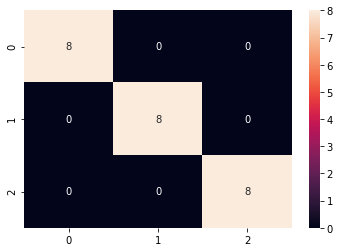

In [26]:
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['Leaf smut']
The actual label for this image is:  Leaf smut


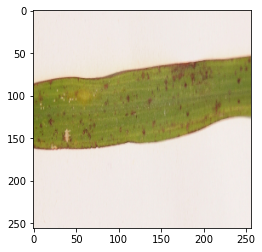

In [27]:
#Check results on a few select images according the test data.
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])
